In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import pickle
from itertools import product
import pandas as pd
plt.rcParams["figure.figsize"] = np.array([6.0, 4.0])*.8

from sys import path as syspath
syspath.append("../functions/")

def tally(x):
    a = pd.Series(x).value_counts().sort_index()
    return list(zip(a.index,a))

bases = 'acgt'
lett_to_index = dict(zip(bases,range(4)))

`mutDict` is a dictionary: for each core sequence region, there is a list of all bins it was observed in.
It was an output of a previous step that searched for exact matches of the flanking regions to cut the core ones out, and also to recognize bar codes that were ligated to sequences after filtering to indicate the bin.

In [2]:
with open('36N_dict.dmp',"rb") as f:
    mutDict = pickle.load(f)

For example, the control sequence was seen most of the times, in all bins.

In [3]:
control = mutDict['control']
del mutDict['control']

controlSeq = "GTGTTGACATAAATACCACTGGCGGTGATACTGAGC".lower()
mutDict[controlSeq] = control

In [4]:
df = pd.DataFrame(mutDict.items(),columns=["sequence","observations"])

ss = []
for s in df.sequence:
    try:
        ss += [s.decode('UTF-8')]
    except:
        ss += [s]

df.sequence = ss
del ss

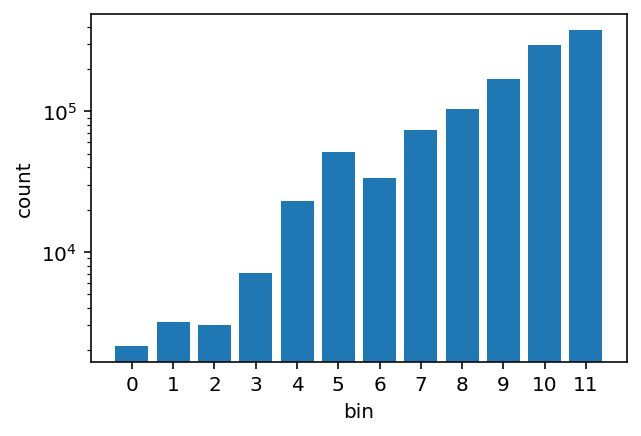

In [5]:
plt.bar(*np.array(tally(control)).T)
plt.xticks(range(12))
plt.xlabel("bin")
plt.ylabel("count")
plt.yscale("log")
plt.savefig("figures/control_counts.pdf")
plt.savefig("figures/control_counts.png",dpi = 300)

Let's have a look at the distribution of the lengths. Note, in the previous step, we accept only those that differ by 2bp from the canonical (36).

Text(0, 0.5, 'count')

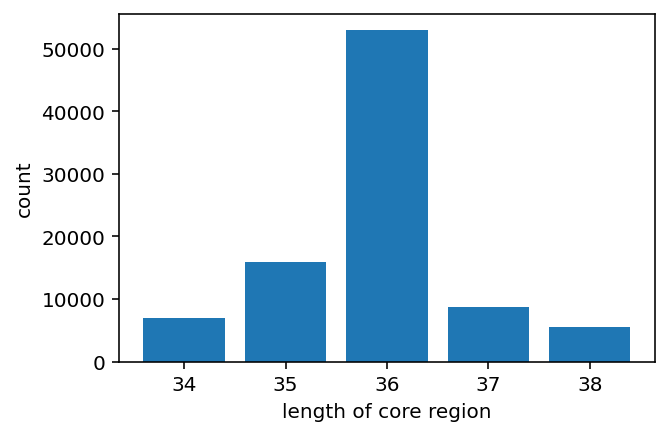

In [6]:
df["core_length"] = list(map(len,df.sequence))

df["coverage"] = list(map(len,df.observations))

cnt = df.core_length.value_counts()
plt.bar(cnt.index, cnt)
# plt.xlim(33.5,38.5)
plt.xlabel("length of core region")
plt.ylabel("count")

Let's have a look at the distribution of the coverages (number of times a read was discovered with the particular core sequence, independent of the bar code, i.e. the bin it was sorted into.

In [7]:
cnt = df.coverage.value_counts().sort_index()
cov, Ncov = cnt.index, cnt.values

(15600.0, 24400.0)

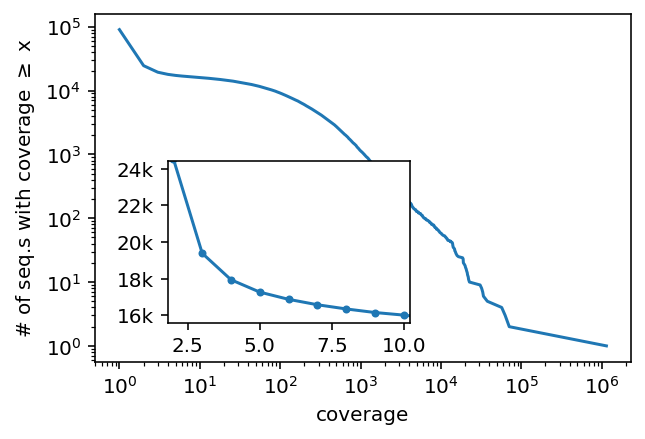

In [8]:
# CDF (sort of)
plt.plot(cov[::-1],np.cumsum(Ncov[::-1]))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("coverage")
plt.ylabel(r"# of seq.s with coverage $\geq$ x")
# plt.grid()
a = plt.axes([.23, .21, .35, .35])
a.plot(cov[::-1],np.cumsum(Ncov[::-1]),".-")
plt.xlim(1.8,10.2)
plt.yticks(np.arange(16,27,2)*1000, ["%ik"%i for i in np.arange(16,27,2)])
plt.ylim(15600,24400)
# plt.grid()

# Investigate noises aroung high-abundant sequences

First ask coverage of at least 2

In [9]:
df = df.query("coverage>=2")

Each abundant sequence comes with a cloud of closely matching sequences which present errors. We should be able to filter them out, but what threshold (in mapping score) to use?

In [10]:
df = df.sort_values("coverage", ascending=False)

What are "high coverage" sequences? Well, here are the coverages of the 100 most abundant:

Text(1.2, 1145052, '$\\leftarrow$ control sequence')

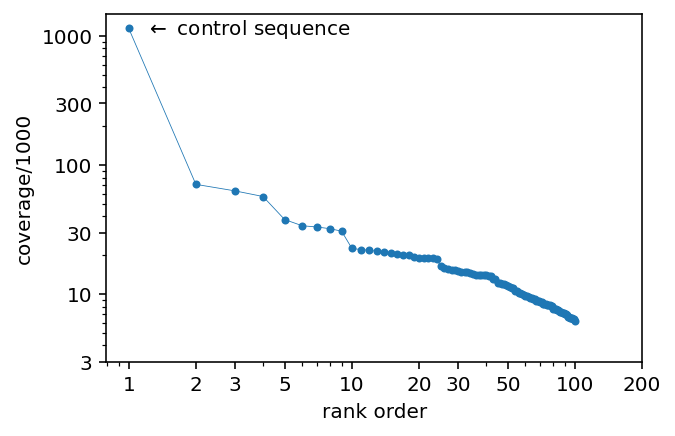

In [11]:
Nshow = 100
plt.plot(1+np.arange(Nshow),df.coverage[:Nshow],".-", lw=.4)
plt.yscale("log")
plt.xscale("log")
yt = np.hstack([i*10**np.arange(3,7) for i in [1,3]])[1:-1]
plt.yticks(yt,map(int, yt/1000));
plt.xlabel("rank order")
plt.ylabel("coverage/1000")
xt = list(range(1,4))+list(range(10,40,10))+[100,200] + [5,50]
plt.xticks(xt, xt)
plt.text(1.2,df.coverage.iloc[0],r"$\leftarrow$ control sequence", va="center")

Investigate matching scores (in percentage) of the 1000 most abundant sequences:

In [12]:
# if done it previously, so just import
matches = np.load("matches_1000.npy")

In [13]:
# Otherwise:

In [14]:
# %%time

# from general_functions import moving_average
# from general_functions import multi_map
# from sequence_functions import printseqs, aln
# def iterf(highCountSeq_):
#     return np.array([aln(highCountSeq_,s)[2]/len(highCountSeq_) for s in df.sequence])


# matches = multi_map(iterf, df.sequence[:1000], processes=15)

# matches = np.vstack(matches)

# np.save("matches_%i.npy"%len(matches),matches,)

In [15]:
# consistency check: diagonals must be 1's
assert (np.diag(matches)==1).all()

In [16]:
dx = .02
bb = np.arange(0.16,1.+dx,dx)+dx/2

In [17]:
from scipy.stats import distributions as dst

In [18]:
cc = np.array([np.histogram(dst.norm.rvs(loc=m,scale=dx/2),bb, density=False)[0] for m in matches])

(0.3, 9800.127763109755)

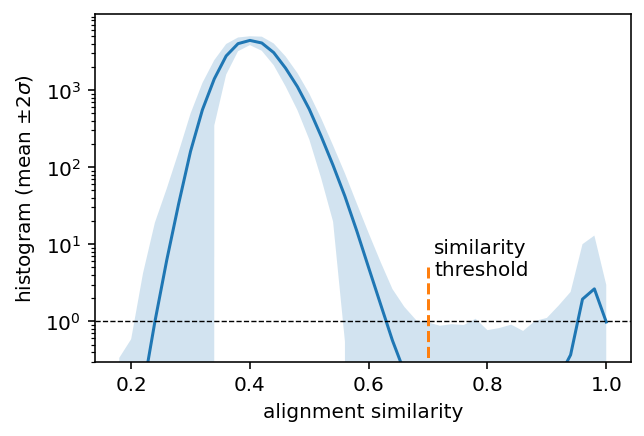

In [19]:
simTh = .7
plt.plot((bb[:-1]+bb[1:])*.5,np.mean(cc, axis=0))
plt.fill_between(
    (bb[:-1]+bb[1:])*.5,
    np.mean(cc, axis=0)+2*np.std(cc, axis=0),
    np.mean(cc, axis=0)-2*np.std(cc, axis=0),
    alpha = .2)
plt.yscale("log")
plt.axhline(1,ls="--",color="k",lw=.7)

plt.plot([simTh,simTh],[1e-2,5], ls="--")
plt.text(simTh+.01,4,"similarity\nthreshold")
plt.xlabel("alignment similarity")
plt.ylabel(r"histogram (mean $\pm 2\sigma$)")
# plt.xlim(.6,)
plt.ylim(.3,)
# plt.savefig("figures/alignment_similarity_histogram.pdf")
# plt.savefig("figures/alignment_similarity_histogram.png", dpi = 300)

In [20]:
from scipy.stats import linregress

In [21]:
bb = np.unique((2**np.linspace(1,np.log2(1e5),100)).astype(int))-.5
x = (bb[:-1]+bb[1:])/2

sequences similar to control
sequences similar to top
10, 100 and 1,000 most covered
None
None


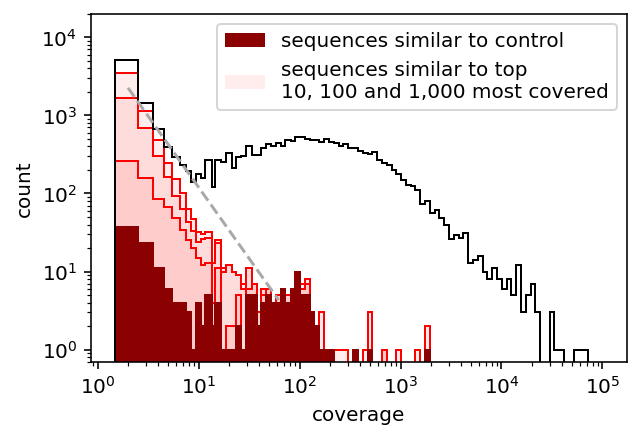

In [22]:
h = plt.hist(df.coverage,bb,histtype="step",color="k")[0]
n = np.where(np.diff(x)==1)[0][-1]

# plt.plot(x[2:n],h[2:n],".")


lr = linregress(np.log(x[2:n]),np.log(h[2:n]))
k = 25#len(x)
h_noise = np.exp(lr.slope*np.log(x[:k])+lr.intercept)
plt.plot(x[:k],h_noise[:k],color="darkgrey",ls="--")

# plt.plot(x[2:n],h[2:n],".")
# lr = linregress(np.log(x[2:n]),np.log(h[2:n]))
# plt.plot(np.log(x), np.exp(lr.slope*x+lr.intercept))

cloud_indices = set()
# for i in range(len(matches)):
# ishow = np.array([1,10,20,50,100,200,500])
ishow = np.array([1,10,100,1000])
for i in range(len(matches)):
    for j in i+np.where(matches[i,i+1:]>simTh)[0]:
        cloud_indices.add(j)
    if i in ishow-1:
        lbl = {
            1:"sequences similar to control",
            ishow[1]:"sequences similar to top\n10, 100 and 1,000 most covered",
                 }.get(i+1,None)
        print (lbl)
        plt.hist(df.coverage.iloc[list(cloud_indices)],bb, zorder=-i,
                 color="red" if i>0 else "darkred",
                 alpha= .07 if i>0 else 1,
                 label=lbl,
#                  color=plt.cm.jet(i/len(matches)),
#                  alpha = .1
                )
        plt.hist(df.coverage.iloc[list(cloud_indices)],bb, zorder=-i,
                 color="red" if i>0 else "darkred",
                 histtype="step"
                )
# plt.text( 20,100, "sequences that are\nsimilar to first 50, 100, 200\nand 500 sequences\n(in order of coverage)",va="bottom")
plt.xscale("log")
plt.yscale("log")
plt.ylim(.7,2e4)
plt.legend()
plt.xlabel("coverage")
plt.ylabel("count")

plt.savefig("figures/coverage_histogram.pdf")
plt.savefig("figures/coverage_histogram.png", dpi = 300)

Essentially, all sequences with coverage less than ~10 are noise. Remove those for now and go further.

In [23]:
newCoverageThreshold = 10
toRemove = list(df.index[list(cloud_indices)])
toRemove += list(df.query(f"coverage<{newCoverageThreshold}").index)
toRemove = np.unique(toRemove)

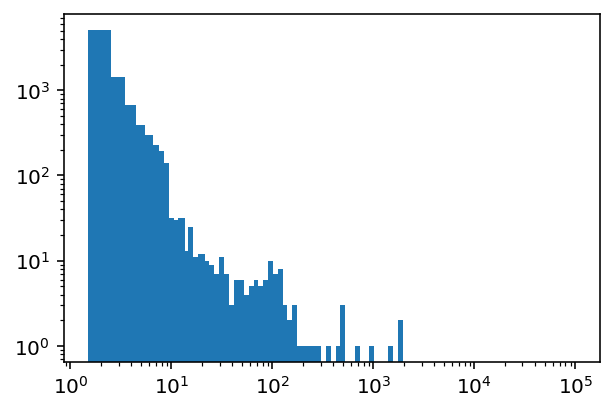

In [24]:
plt.hist(df.coverage.loc[toRemove],bb)
plt.xscale("log")
plt.yscale("log")

In [25]:
df.drop(index=toRemove, inplace=True)

# Construct distributions and filter on estimates

In [26]:
Nlevels = 12
df["raw_dist"] = [np.array([np.sum(np.array(row.observations)==l) for l in range(Nlevels)])/row.coverage for i,row in df.iterrows()]
bias = df.raw_dist.iloc[0]
df["debiased_dist"] = [(d/bias)/(d/bias).sum() for d in df.raw_dist]

# drop the control sequence
df.drop(index=df.index[0], inplace=True)

In [27]:
df["mode_debiased"] = df.debiased_dist.apply(np.argmax)
df["prelim_median"] = [np.argmin(np.abs(np.cumsum(d)-.5)) for d in df.debiased_dist]
df["prelim_mean"] = [(d*np.arange(Nlevels)).sum() for d in df.debiased_dist]

In [28]:
tol = 3

In [29]:
toRemove = df[np.abs(df.mode_debiased-df.prelim_mean)>=tol].index
len(toRemove)

45

In [30]:
df.drop(index=toRemove, inplace=True)

In [31]:
toRemove = df[np.abs(df.prelim_mean-df.prelim_median)>=tol].index
len(toRemove)

329

In [32]:
df.drop(index=toRemove, inplace=True)

# Create template distributions

In [33]:
M = np.vstack([df_mode.debiased_dist.mean(0) for mode, df_mode in df.groupby("mode_debiased")])

In [34]:
assert np.all(np.abs(M.sum(1)-1)<1e-5)

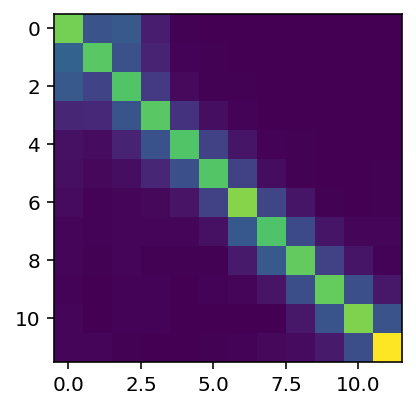

In [35]:
plt.imshow(M)

In [36]:
def polynom(c, x):
    out = [k*x**j for j,k in enumerate(c)]
    return np.sum(out, axis=0)

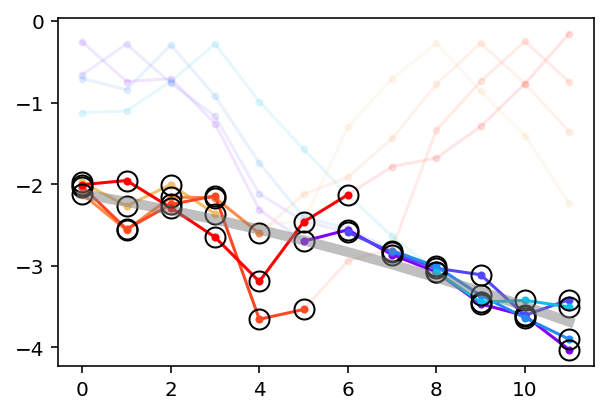

In [37]:
points = []
ne = 4
for i in list(range(Nlevels))[:ne]+list(range(Nlevels))[-ne:]:
    mm = M[i]
    plt.plot(np.arange(Nlevels),np.log10(mm),".-",
            c=plt.cm.rainbow(np.linspace(0,1,Nlevels)[i]),
                label=i, alpha = .1
            )
    x = np.abs(np.arange(Nlevels)-i)>4
    plt.plot(np.arange(Nlevels)[x],np.log10(mm[x]),".-",
            c=plt.cm.rainbow(np.linspace(0,1,Nlevels)[i]))
    points += list(np.array([np.arange(Nlevels)[x],np.log10(mm[x])]).T)
# plt.yscale("log")

plt.plot(*np.array(points).T,color="k", marker="o",mfc="none", ls='none', ms=10)

pBackground = np.polyfit(*np.array(points).T,deg=2)[::-1]

x  = np.arange(Nlevels)
plt.plot(x,polynom(pBackground,x),lw=5,c="grey",alpha = .5)

Text(0.5, 1.0, 'PDFs after debiasing')

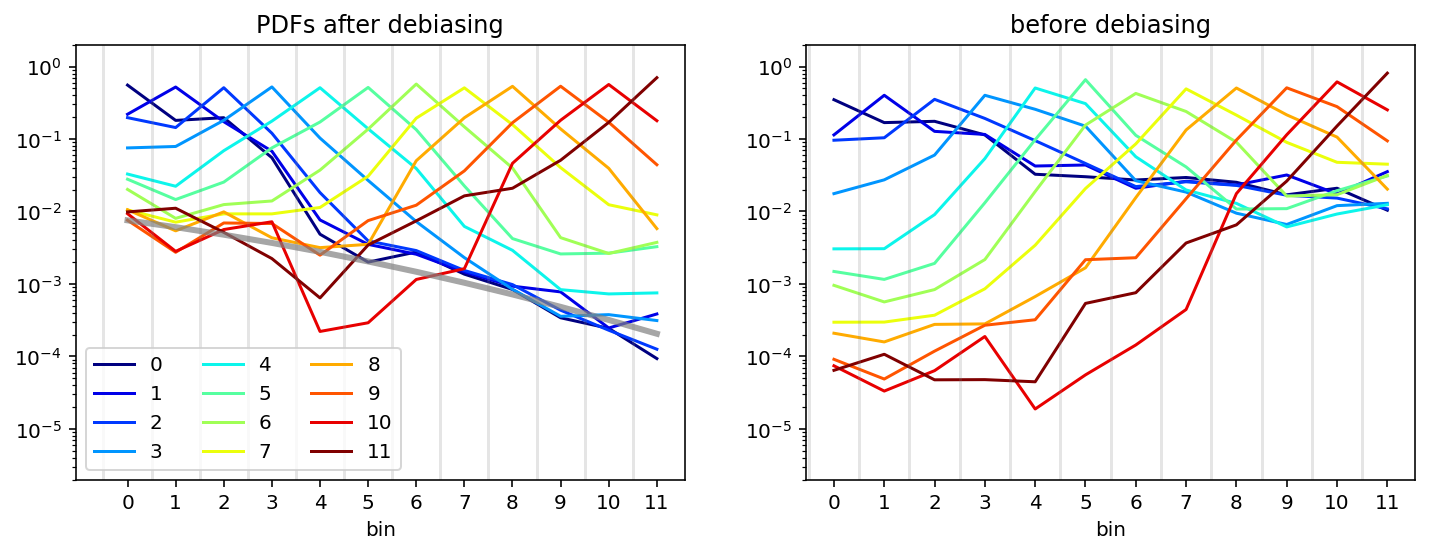

In [38]:
plt.figure(figsize=(12,4))
axs = [plt.subplot(1,2,i) for i in [2,1]]
for i in range(Nlevels):
    mm = M[i]
    axs[1].plot(np.arange(Nlevels)[mm>1e-6],mm[mm>1e-6],
            label=i,
            c=plt.cm.jet(np.linspace
                         (0,1,Nlevels)[i])
            )
    mm = M[i]*bias
    mm = mm/mm.sum()
    axs[0].plot(np.arange(Nlevels)[mm>1e-6],mm[mm>1e-6],
            c=plt.cm.jet(np.linspace(0,1,Nlevels)[i]),
                label=i
            )

for ax in axs:
    ax.set_yscale("log")
    ax.set_xticks(range(Nlevels))
    ax.set_xlabel("bin")
    ax.set_xticklabels([str(j) for j in range(Nlevels)])
    ax.set_ylim(2e-6,2)
    for i in range(Nlevels):
        ax.axvline(i-.5,color="grey", alpha = .2)
axs[1].legend(ncol=3,loc=3)

x  = np.arange(Nlevels)
y = 10**polynom(pBackground,x)
axs[1].plot(x,y,lw=3,c="grey",alpha = .7)

x,y = np.array(points).T
# axs[1].plot(x,10**y,color="k", marker="o",mfc="none", ls='none', ms=7, alpha = .4)

axs[0].set_title("before debiasing")
axs[1].set_title("PDFs after debiasing")
# plt.savefig("figures/template_distributions.pdf")
# plt.savefig("figures/template_distributions.png", dpi = 300)

In [39]:
bkg = 10**polynom(pBackground,np.arange(Nlevels))

In [40]:
filters = np.array([np.abs(mm/bkg-1)>2 for mm in M])
for i in range(Nlevels):
    for j in range(Nlevels):
        if np.abs(j-i)>=5:
            filters[i,j] = False

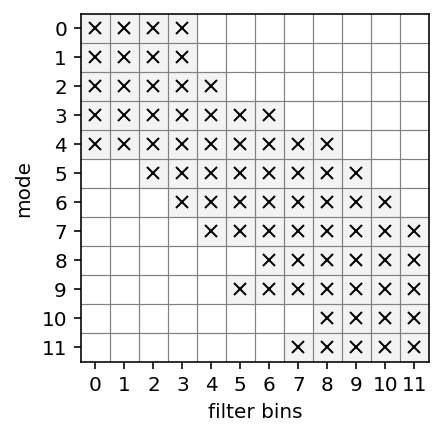

In [41]:
plt.imshow(filters, cmap="Greys", vmax=1e1)
x,y = np.where(filters.T)
plt.plot(x,y,"kx")
plt.xticks(range(Nlevels))
plt.yticks(range(Nlevels));
plt.xlabel('filter bins')
plt.ylabel('mode')
for i in range(Nlevels-1):
    plt.axhline(i+.5, color="grey", lw=.6)
    plt.axvline(i+.5, color="grey", lw=.6)
plt.savefig("figures/filters.png", dpi = 300)
plt.savefig("figures/filters.pdf")

In [42]:
cleaned_distribs = np.zeros((len(df), Nlevels))

for i in range(len(df)):
    f = df.debiased_dist.iloc[i].copy()
    m = df.mode_debiased.iloc[i]
    f = f*filters[m]
    f = f/f.sum()
    cleaned_distribs[i] = f

In [43]:
df["cleaned_dist"] = list(cleaned_distribs)
df["est_mean"] = [(d*np.arange(Nlevels)).sum() for d in df.cleaned_dist]
df["est_err"] = [(d*np.arange(Nlevels)**2).sum()-m**2 for m,d in zip(df.est_mean, df.cleaned_dist)]

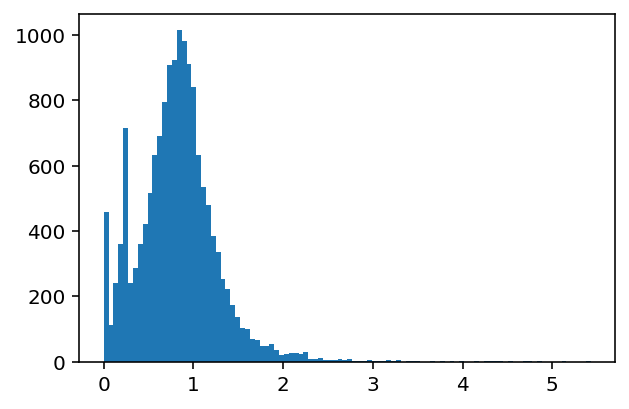

In [44]:
plt.hist(df.est_err,100);

In [45]:
df = df.query(f"est_err<{tol}").copy()

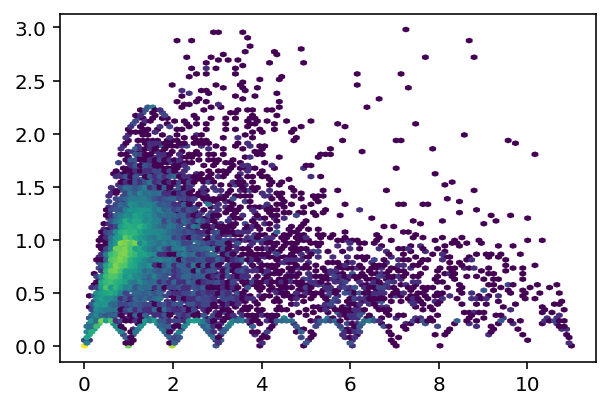

In [46]:
# plt.plot(df.est_mean, df.est_err,'.')
plt.hexbin(df.est_mean, df.est_err, mincnt=1, bins="log")

# Calculate estimate in FACS units

In [47]:
# from email
logBbinMedians = np.log10(np.array('9	59	103	183	349	649	1206	2236	4416	7660	14254	30631'.split("\t"),dtype=float))

In [48]:
df["estimate_facs"] = [(d*logBbinMedians).sum() for d in df.cleaned_dist]

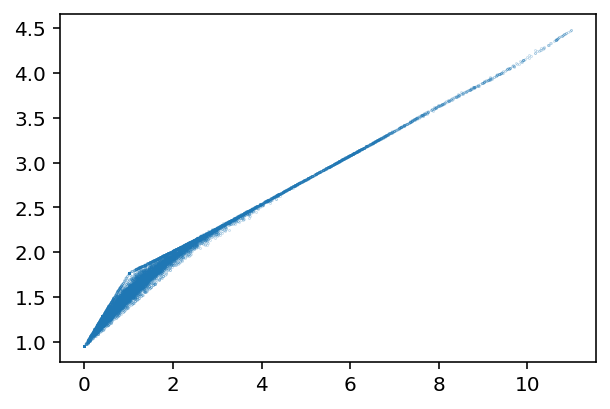

In [49]:
plt.plot(df.est_mean, df.estimate_facs,".", ms=.2)

# Save

In [50]:
df = df[['sequence', 'est_mean', 'est_err', 'estimate_facs', 'coverage']]

In [51]:
df = df.rename({
    "est_mean":"estimate_bin",
    "est_err":"estimate_bin_err"
},axis="columns")

In [52]:
construct = pd.read_excel("96 picks sequences.xlsx", sheet_name="Flanking sequences").columns[0]
flanks = [fl.lower() for fl in construct.split("N"*36)]

In [53]:
add = 40

In [54]:
df.sequence = [flanks[0][-add:] + s + flanks[1][:add] for s in df.sequence]

In [55]:
df.to_csv("36N_constitutive_all.csv", index=False)

In [56]:
df = df.query("coverage>=30").copy()

In [57]:
df.to_csv("36N_constitutive.csv", index=False)